# CNN training for pattern recognition on Range-Doppler Heatmap (3D) and Static Range-Azimuth Heatmap (2D)

In [1]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Gathering the databases

In [2]:
# Doppler CNN files paths
feature_sets_path  = os.getcwd()
filename_dop = 'all_targets_doppler_1202_4497'
features_filename_dop = filename_dop + '.npz'
dop_model_filename = filename_dop + '.h5'

In [3]:
# Azimuth CNN files paths
filename_az = 'all_targets_azimuth_0_11490'
features_filename_az = filename_az + '.npz'
az_model_filename = filename_az + '.h5'

In [4]:
# Load feature sets
features_set_dop = np.load(join(feature_sets_path, features_filename_dop))
print('features for doppler set:',features_set_dop.files)

features_set_az = np.load(join(feature_sets_path, features_filename_az))
print('features for azimuth set:',features_set_az.files)

features for doppler set: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']
features for azimuth set: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign Doppler feature sets
x_train_dop = features_set_dop['x_train']
y_train_dop = features_set_dop['y_train']
x_val_dop = features_set_dop['x_val']
y_val_dop = features_set_dop['y_val']
x_test_dop = features_set_dop['x_test']
y_test_dop = features_set_dop['y_test']

In [6]:
# Assign Azimuth feature sets
x_train_az = features_set_az['x_train']
y_train_az = features_set_az['y_train']
x_val_az = features_set_az['x_val']
y_val_az = features_set_az['y_val']
x_test_az = features_set_az['x_test']
y_test_az = features_set_az['y_test']

In [7]:
# Look at tensor dimensions
print('Doppler:')
print('training input shape :',x_train_dop.shape)
print('validation input shape :',x_val_dop.shape)
print('test input shape :',x_test_dop.shape)

print('Azimuth:')
print('training input shape :',x_train_az.shape)
print('validation input shape :',x_val_az.shape)
print('test input shape :',x_test_az.shape)

Doppler:
training input shape : (5610, 512, 4)
validation input shape : (1200, 512, 4)
test input shape : (1200, 512, 4)
Azimuth:
training input shape : (215040, 15)
validation input shape : (46080, 15)
test input shape : (46080, 15)


In [8]:
# Sample shape
NUMBER_ROWS_DOP = 15
NUMBER_COlUMNS_DOP = 512
NUMBER_ROWS_AZ = 512
NUMBER_COlUMNS_AZ = 15
DEPTH = 4

In [9]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

# Doppler
x_train_dop = x_train_dop.reshape(int(x_train_dop.shape[0]/(NUMBER_ROWS_DOP)),
                          NUMBER_ROWS_DOP,
                          NUMBER_COlUMNS_DOP,
                          DEPTH,
                          1)
x_val_dop = x_val_dop.reshape(int(x_val_dop.shape[0]/(NUMBER_ROWS_DOP)),
                      NUMBER_ROWS_DOP,
                      NUMBER_COlUMNS_DOP,
                      DEPTH,
                      1)
x_test_dop = x_test_dop.reshape(int(x_test_dop.shape[0]/(NUMBER_ROWS_DOP)),
                        NUMBER_ROWS_DOP,
                        NUMBER_COlUMNS_DOP,
                        DEPTH,
                        1)

print('number of training samples :',x_train_dop.shape[0])
print('number of validation samples :',x_val_dop.shape[0])
print('number of test samples :',x_test_dop.shape[0])

sample_shape_dop = x_test_dop.shape[1:]
print('sample shape :',sample_shape_dop)

number of training samples : 374
number of validation samples : 80
number of test samples : 80
sample shape : (15, 512, 4, 1)


In [10]:
# Azimuth
x_train_az = x_train_az.reshape(int(x_train_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)
x_val_az = x_val_az.reshape(int(x_val_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)
x_test_az = x_test_az.reshape(int(x_test_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of training samples :',x_train_az.shape[0])
print('number of validation samples :',x_val_az.shape[0])
print('number of test samples :',x_test_az.shape[0])

sample_shape_az = x_test_az.shape[1:]
print('sample shape :',sample_shape_az)

number of training samples : 420
number of validation samples : 90
number of test samples : 90
sample shape : (512, 15, 1)


## 3D Model construction and training (Range-Doppler Heatmap pattern recognition)

### Model Construction

In [71]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_dop = models.Sequential()

# Convolution filters
model_dop.add(layers.Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_dop, name = 'Conv3D_layer1'))
model_dop.add(layers.MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer1'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=16, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer2'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer2'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=32, kernel_size=(2,2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer3'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer3'))
model_dop.add(Dropout(0.5))

# Classifier
model_dop.add(Flatten())
model_dop.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))
model_dop.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))


# Check Number of Classes Before Training
model_dop.add(Dense(2, activation='sigmoid'))

# Display model
model_dop.layers
model_dop.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv3D_layer1 (Conv3D)          │ (None, 15, 512, 4, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling3D)   │ (None, 7, 256, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 7, 256, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer2 (Conv3D)          │ (None, 7, 256, 4, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling3D)   │ (None, 3, 128, 4, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 3, 128, 4, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer3 (Conv3D)          │ (None, 3, 128, 4, 32)  │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling3D)   │ (None, 1, 64, 4, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 1, 64, 4, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,722 (4.05 MB)

 Trainable params: 1,060,722 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [72]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)

# Add training parameters to model
model_dop.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.01,
             metrics=['accuracy'])

# Train
history_dop = model_dop.fit(x_train_dop,
                   y_train_dop,
                   epochs=250,
                   batch_size=8,
                   validation_data=(x_val_dop,y_val_dop),
                   callbacks = [es])

Epoch 1/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6670 - loss: 0.0068 - val_accuracy: 0.6250 - val_loss: 0.0067
Epoch 2/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7013 - loss: 0.0063 - val_accuracy: 0.6250 - val_loss: 0.0068
Epoch 3/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6857 - loss: 0.0065 - val_accuracy: 0.6250 - val_loss: 0.0066
Epoch 4/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6418 - loss: 0.0066 - val_accuracy: 0.6250 - val_loss: 0.0066
Epoch 5/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6862 - loss: 0.0065 - val_accuracy: 0.6250 - val_loss: 0.0066
Epoch 6/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6630 - loss: 0.0065 - val_accuracy: 0.6250 - val_loss: 0.0066
Epoch 7/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6802 - loss: 0.0065 - val_accuracy: 0.6250 - val_loss: 0.0065
Epoch 8/250
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6723 - loss: 0.0063 - val_accuracy: 0.

### Plotting results

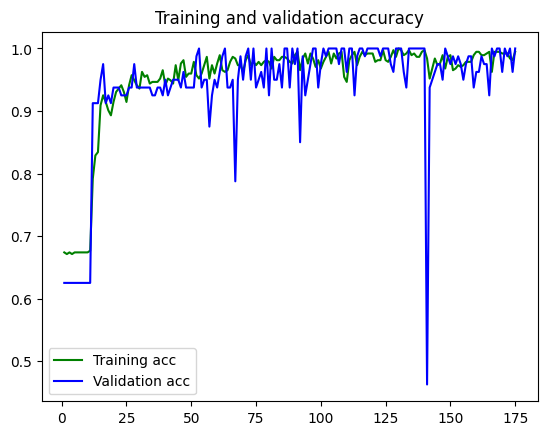

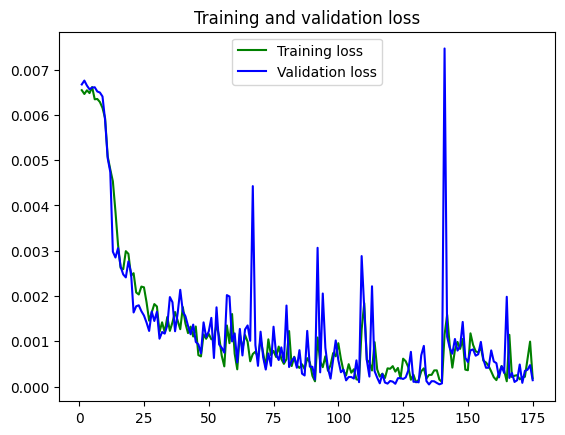

In [73]:
# Plot results
import matplotlib.pyplot as plt

acc = history_dop.history['accuracy']
val_acc = history_dop.history['val_accuracy']
loss = history_dop.history['loss']
val_loss = history_dop.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
# Model evaluation on test set
test_loss, test_acc = model_dop.evaluate(x_test_dop, y_test_dop, verbose=2)

3/3 - 0s - 85ms/step - accuracy: 0.9750 - loss: 4.9534e-04


In [75]:
# Save the model as a file
with open(os.getcwd() + '\\file.txt', 'w') as f:
  f.write(os.getcwd())

models.save_model(model_dop, feature_sets_path + '\\' + dop_model_filename)

print('saved model path :',feature_sets_path + '/' + dop_model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code/all_targets_doppler_1202_4497.h5


## 2D Model construction and training

### Model construction

In [42]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_az = models.Sequential()

# Convolution filters
model_az.add(layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_az, name = 'Conv2D_layer1'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer1'))

model_az.add(layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer2'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer2'))

model_az.add(layers.Conv2D(filters=64, kernel_size=(2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer3'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer3'))

# Classifier
model_az.add(Flatten())
model_az.add(Dense(2048, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))
model_az.add(Dense(512, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))
model_az.add(Dense(64, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))

# Check Number of Classes Before Training
model_az.add(Dense(2, activation='sigmoid'))

# Display model
model_az.layers
model_az.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 512, 15, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling2D)   │ (None, 256, 7, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 256, 7, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling2D)   │ (None, 128, 3, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 128, 3, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling2D)   │ (None, 64, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,485,762 (36.19 MB)

 Trainable params: 9,485,762 (36.19 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [43]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)

# Add training parameters to model
model_az.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.001,
             metrics=['accuracy'])

# Train
history_az = model_az.fit(x_train_az,
                   y_train_az,
                   epochs=500,
                   batch_size=4,
                   validation_data=(x_val_az,y_val_az),
                   callbacks = [es])

Epoch 1/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.6392 - loss: 6.6073e-04 - val_accuracy: 0.8444 - val_loss: 4.1951e-04
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8765 - loss: 3.4135e-04 - val_accuracy: 1.0000 - val_loss: 1.9176e-06
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.8982e-06 - val_accuracy: 1.0000 - val_loss: 1.9272e-07
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.3838e-07 - val_accuracy: 1.0000 - val_loss: 3.6626e-08
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 1.0000 - loss: 2.9562e-07 - val_accuracy: 1.0000 - val_loss: 9.3662e-09
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 1.0000 - loss: 2.1479e-07 - val_accuracy: 1.0000 - val_loss: 9.6821e-08
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 1.0000 - loss: 3.9561e-07 - val_accuracy: 1.0000 - val_loss: 1.9705e-08
Epoch 8/500
105/105 

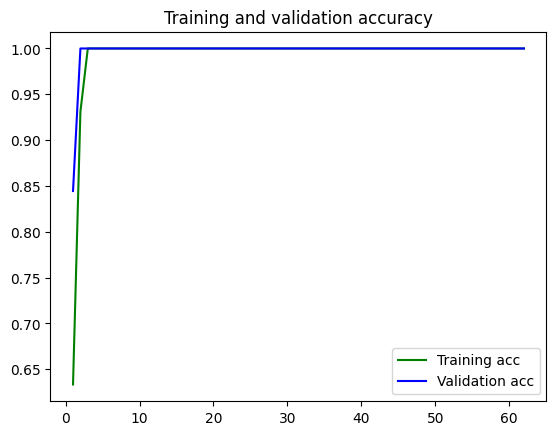

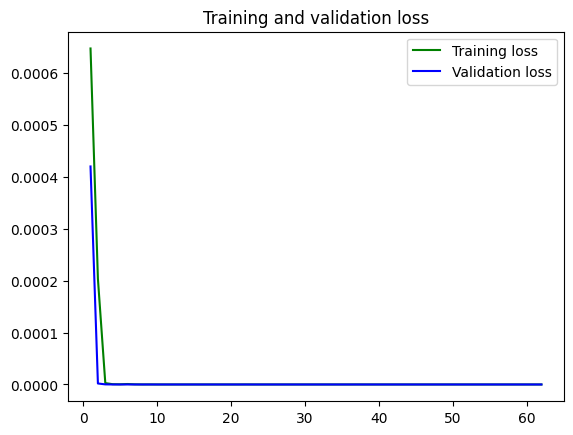

In [44]:
# Plot results
import matplotlib.pyplot as plt

acc = history_az.history['accuracy']
val_acc = history_az.history['val_accuracy']
loss = history_az.history['loss']
val_loss = history_az.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [45]:
# Model evaluation on test set
test_loss, test_acc = model_az.evaluate(x_test_az, y_test_az, verbose=2)

3/3 - 0s - 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [47]:
# Save the model as a file
with open(os.getcwd() + '\\file.txt', 'w') as f:
  f.write(os.getcwd())

models.save_model(model_az, feature_sets_path + '\\' + az_model_filename)

print('saved model path :',feature_sets_path + '/' + az_model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code/all_targets_azimuth_0_11490.h5


## Confusion matrix

In [37]:
import seaborn as sns
import tensorflow as tf


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


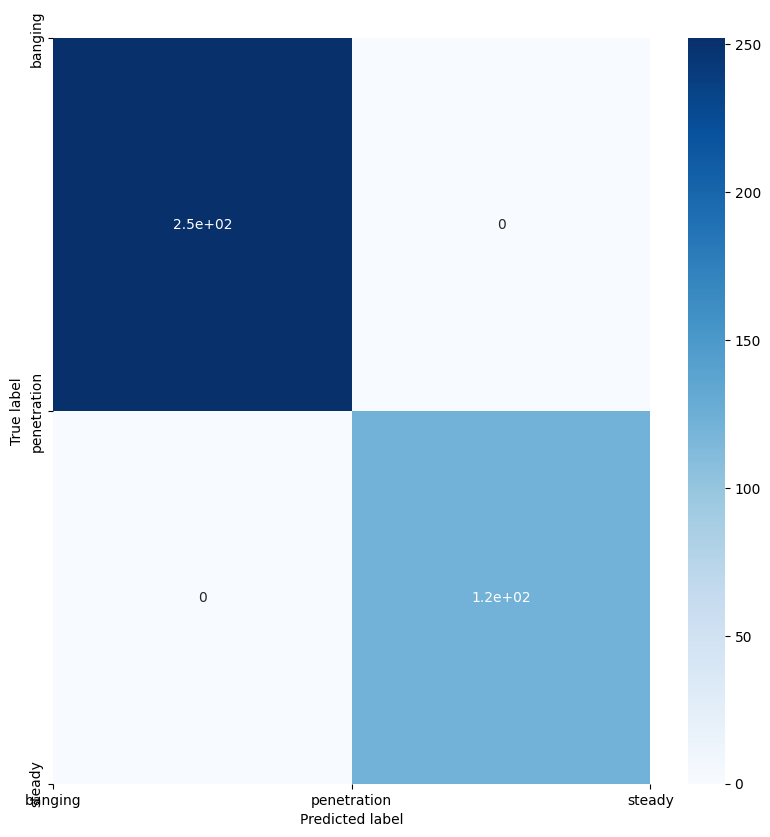

In [38]:
y_true=y_train_dop
predict_y=model_dop.predict(x_train_dop)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


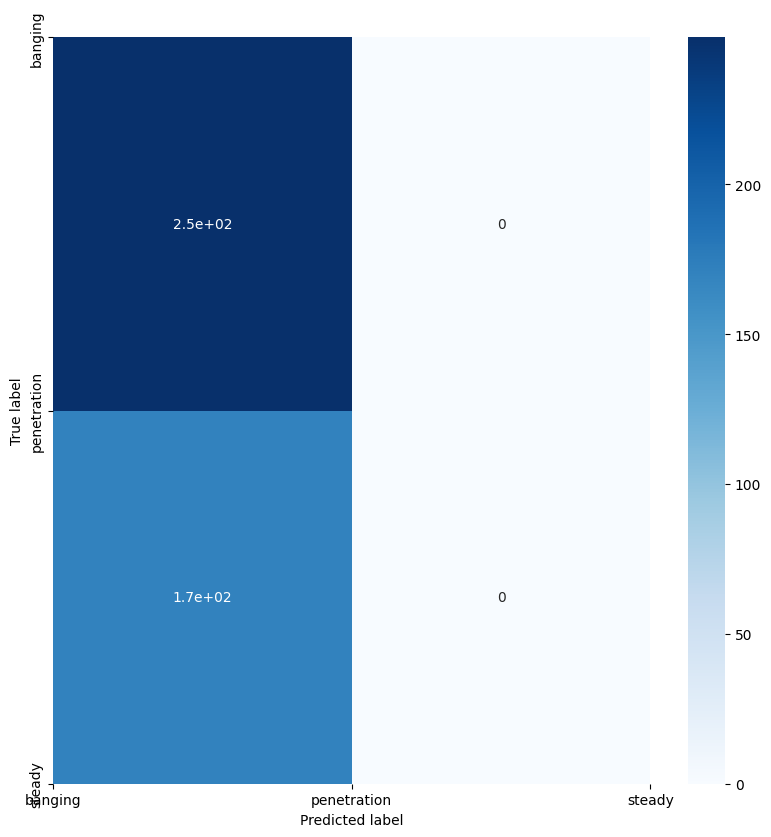

In [39]:
y_true=y_train_az
predict_y=model_az.predict(x_train_az)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()


In [24]:
# Prediction test with unclassified parameters
import scipy.interpolate as spi

# Load archive with the data to be predicted .npz
test_npz = np.load(os.getcwd()+'\\all_targets_0_13017_test_classes_55.npz')
test_in = test_npz['x_test']                                  

print(test_in.shape)
test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS_AZ)),                  # Resize with sample shape
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on test sample pack
label = model_az.predict(test_in_reshape)
num_samples = test_in_reshape.shape[0]

# Loop throught the sample pack to display some of the predictions
for i in range (0,num_samples,10):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[128*i:128*(i+1),:].reshape(
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ)
    range_res = 0.0436
    range_bins = sample.shape[0]
    angle_bins = sample.shape[1]
    theta = np.arcsin(np.linspace(-angle_bins / 2 + 1, angle_bins / 2 - 1, angle_bins) * (2 / angle_bins))  # Angular linear space for plotting
    range = np.linspace(0, range_bins - 1, range_bins) * range_res                                          # Range linear space for plotting
    range = np.maximum(range,0)                                                                                 # Keep only positive range value (later add range bias correction)
    range_depth = range_bins * range_res                                                         
    range_width, grid_res = range_depth/2, 64

    # Grid construction
    posX = np.outer(range, np.sin(theta))
    posY = np.outer(range, np.cos(theta))
    xlin = np.linspace(-np.floor(range_width), np.ceil(range_width), angle_bins)
    ylin = np.linspace(0, range_depth, range_bins)
    xgrid, ygrid = np.meshgrid(xlin, ylin)
    ra_grid = spi.griddata((posX.flatten(), posY.flatten()), sample.flatten(),(xgrid, ygrid), method='cubic')
    grid_init = 1
        
    hmplot = plt.contourf(xlin,ylin,sample,cmap='Spectral_r')
    plt.title(i)
    plt.show()
    #print("Expected prediction : ",expected[i],"\n")


"""     fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto') """ #Doppler plotting

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Iman\\Desktop\\Stage\\code\\all_targets_0_13017_test_classes_55.npz'